# Meta-heuristic Optimization benchmark

These are the meta-heuristic algorithms we are comparing in this notebook:

- Particle Swarm Optimization
- Firefly Algorithm
- Gray Wolf Optimization

In [35]:
from hyperopt import fmin, rand, tpe, hp,Trials
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})

## Auxiliary functions

In [2]:
def run(population_count, max_eval, algorithm, problem, dim, ha = 0, hb = 0, hc = 0, hd = 0):
    result = subprocess.run(['../bin/examples/benchmark/benchmark', 
                             '-o', '2', '-n', str(dim), '-p', str(population_count), 
                             '-eta', str(max_eval), '-a', str(algorithm), '-s', str(problem), 
                             '-ha', str(ha), '-hb', str(hb), '-hc', str(hc), '-hd', str(hd)], stdout=subprocess.PIPE)
    
    time, fitness = result.stdout.split()
    
    return (int(time), float(fitness))

In [3]:
def hpo_pso(population_count, problem, dim):
    
    def f_obj(p):
        return run(population_count, 1000, 0, problem, dim, p['G'], p['L'], p['Mi'], p['Ma'])[1]
    
    space = {'G': hp.uniform('G', 0.1, 0.9), 
             'L': hp.uniform('L', 0.1, 0.9), 
             'Mi': hp.uniform('Mi', 0.1, 0.6), 
             'Ma': hp.uniform('Ma', 0.6, 0.9)}

    best = fmin(f_obj, space = space, algo = tpe.suggest, max_evals = 100)         

    return best

In [4]:
def hpo_fa(population_count, problem, dim):
    
    def f_obj(p):
        return run(population_count, 1000, 1, problem, dim, p['Ld'], p['Ib'], p['Ri'])[1]
    
    space = {'Ld': hp.uniform('Ld', 0.1, 0.9), 
             'Ib': hp.uniform('Ib', 0.1, 0.9), 
             'Ri': hp.uniform('Ri', 0.1, 0.9)}

    best = fmin(f_obj, space = space, algo = tpe.suggest, max_evals = 100)         

    return best

## Benchmark optimization problems

In [8]:
problems = [0, 1, 2, 3, 4, 5, 6, 7, 8]
names = ['De Jung', 'Ackley', 'Giewangk', 'Rastrigin', 'Rosenbrock', 'Schwefel', 'Styblinski-Tang', 'Step', 'Alpine']
trials = range(10)

hyper_columns = [['PSO', 'PSO', 'PSO', 'PSO', 'FA', 'FA', 'FA', 'CS', 'CS', 'CS'], ['G', 'L', 'Mi', 'Ma', 'Ld', 'Ib', 'Ri']]
hyper_tuples = list(zip(*hyper_columns))

df_time = pd.DataFrame(index = pd.MultiIndex.from_tuples(itertools.product(names, trials), names = ['Problema', 'Trial']), columns = ['PSO', 'FA', 'GWO'])
df_fitness = pd.DataFrame(index = pd.MultiIndex.from_tuples(itertools.product(names, trials), names = ['Problema', 'Trial']), columns = ['PSO', 'FA', 'GWO'])
df_hyper = pd.DataFrame(index = names, columns = pd.MultiIndex.from_tuples(hyper_tuples, names = ['Algorithm', 'Hyper-parameter']))

### PSO

In [9]:
for problem, name in zip(problems, names):
    best = hpo_pso(40, problem, 10)
    G, L, Mi, Ma = best['G'], best['L'], best['Mi'], best['Ma']
    
    for trial in trials:
        time, fitness = run(10, 1000, 0, problem, 10, G, L, Mi, Ma)
        
        df_time.loc[(name, trial), 'PSO'] = time
        df_fitness.loc[(name, trial), 'PSO'] = fitness
    
    df_hyper.loc[name, ('PSO', 'G')] = G
    df_hyper.loc[name, ('PSO', 'L')] = L
    df_hyper.loc[name, ('PSO', 'Mi')] = Mi
    df_hyper.loc[name, ('PSO', 'Ma')] = Ma

### FA

In [10]:
for problem, name in zip(problems, names):
    best = hpo_fa(40, problem, 10)
    Ld, Ib, Ri = best['Ld'], best['Ib'], best['Ri']
    
    for trial in trials:
        time, fitness = run(10, 1000, 1, problem, 10, Ld, Ib, Ri)
        
        df_time.loc[(name, trial), 'FA'] = time
        df_fitness.loc[(name, trial), 'FA'] = fitness
    
    df_hyper.loc[name, ('FA', 'Ld')] = Ld
    df_hyper.loc[name, ('FA', 'Ib')] = Ib
    df_hyper.loc[name, ('FA', 'Ri')] = Ri

### GWO

In [11]:
for problem, name in zip(problems, names):
    for trial in trials:
        time, fitness = run(10, 1000, 3, problem, 10)
        
        df_time.loc[(name, trial), 'GWO'] = time
        df_fitness.loc[(name, trial), 'GWO'] = fitness

## Results

### Fitness

In [12]:
df_fitness_n = df_fitness.astype(np.float32)

In [13]:
df_fitness_summary = df_fitness_n.groupby(['Problema']).mean()

In [17]:
df_fitness_summary.to_latex('fitness.tex', float_format="%.2E")

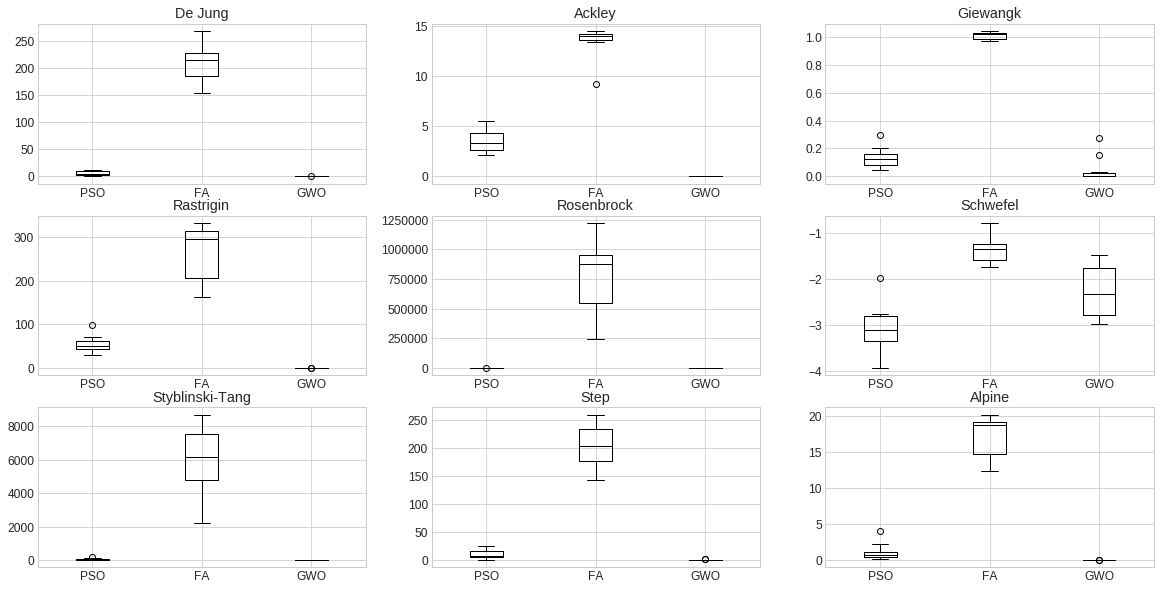

In [50]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10), sharey=False)

for name, axis in zip(names, itertools.chain.from_iterable(ax)):
        df_fitness_n.loc[name].plot(kind='box', ax = axis, showmeans = False, title = name, color='black')
        
fig.savefig('fitness.pdf',bbox_inches='tight')

### Time

In [39]:
df_time_n = df_time.astype(np.float32)

In [40]:
df_time_summary = df_time_n.groupby(['Problema']).mean()

In [41]:
df_time_summary.to_latex('time.tex', float_format="%.2E")

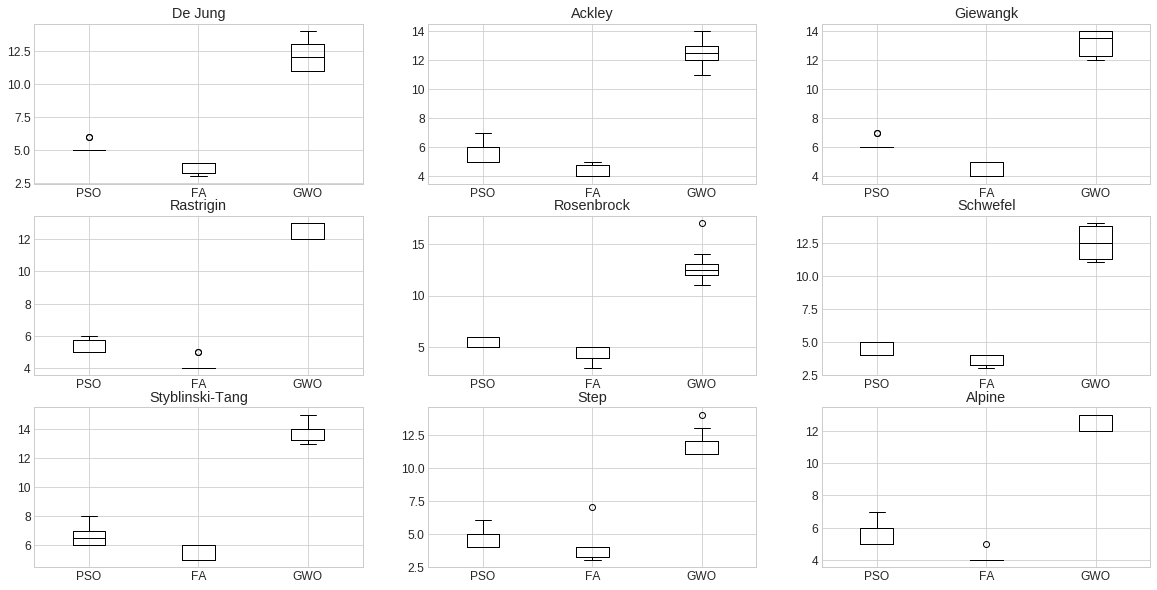

In [48]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10), sharey=False)

for name, axis in zip(names, itertools.chain.from_iterable(ax)):
        df_time_n.loc[name].plot(kind='box', ax = axis, showmeans = False, title = name, color='black')
        
fig.savefig('time.pdf',bbox_inches='tight')

### Hyper-parameters

In [47]:
df_hyper.astype(np.float32).to_latex('hyper.tex', float_format="%.2E")